## Part 2 - Clustering

Importing the required libraries and checking for the python version.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os
import cv2

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Loading only the training dataset for Part 2 of the coursework

In [2]:
CW_DATASET_PATH = "CW_dataset"

def load_train_data(dataset_path=CW_DATASET_PATH):
    x_train_all_path = os.path.join(dataset_path, "x_train_all.csv")
    y_train_all_path = os.path.join(dataset_path, "y_train_all.csv")

    x_train_all = pd.read_csv(x_train_all_path)
    y_train_all = pd.read_csv(y_train_all_path)

    return x_train_all, y_train_all

In [3]:
x_train, y_train = load_train_data()

In [4]:
x_train.shape

(9690, 2304)

In [5]:
y_train.shape

(9690, 1)

### 1) K-means Clustering

Plotted the clusters for the train dataset by using a dimentionality reduction technique called PCA.

In [6]:
def plot_clusters(X, y = None):
    plt.scatter(X[:, 0], X[:, 1],c=y, s=3, alpha=0.7) #s is the size of dots.
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

In [7]:
def plot_figure(title, X, y = None):
    plt.figure(figsize=(8, 4))
    plt.title(title)
    plot_clusters(X, y)
    plt.show()

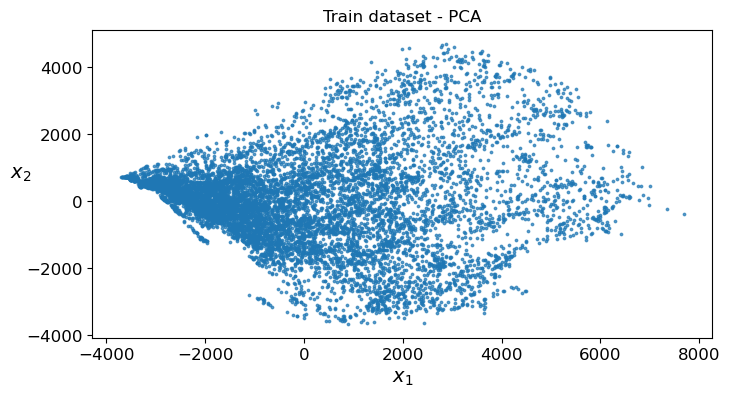

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca1 = pca.fit_transform(x_train, y_train)

plot_figure("Train dataset - PCA", X_pca1)

Preprocessed the train dataset by winsorizing and normalising the data.

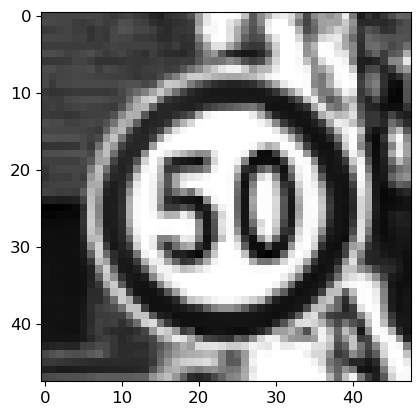

In [9]:
import matplotlib.pyplot as plt

img = x_train.iloc[4391]
img = img.values.reshape((48, 48))

plt.imshow(img, cmap='gray')
plt.show()

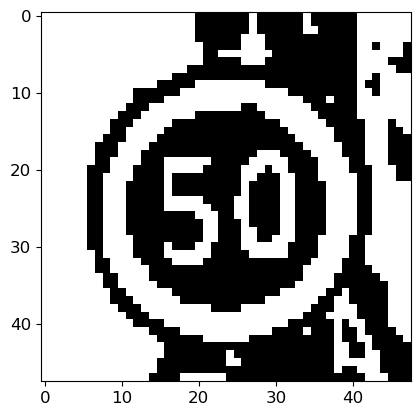

In [10]:
import cv2

ret, thresh1 = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY_INV)
plt.imshow(thresh1,cmap='gray')

In [11]:
threshold_value = 120
threshold_img_xtrain = "thresholded_images"

In [12]:
# Create the output folder if it doesn't exist
if not os.path.exists(threshold_img_xtrain):
    os.makedirs(threshold_img_xtrain)

# Loop through the dataset and apply thresholding
for i in range(len(x_train)):
    img = x_train.iloc[i].values.reshape((48, 48))
    ret, thresh1 = cv2.threshold(img, threshold_value, 255, cv2.THRESH_BINARY_INV)
    output_path = os.path.join(threshold_img_xtrain, f"thresholded_{i}.png")
    cv2.imwrite(output_path, thresh1)

In [13]:
thresholded_images = []
for i in range(len(x_train)):
    img_path = os.path.join(threshold_img_xtrain, f"thresholded_{i}.png")
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    thresholded_images.append(img)

x_train = np.array(thresholded_images)

In [14]:
# smoothed_images = []
# for img in x_train:

#     smoothed = cv2.GaussianBlur(img, (5,5), 0)  # You can adjust the kernel size (e.g., (5, 5)) as needed
#     smoothed_images.append(smoothed)
   

# # Convert the list of smoothed images to a numpy array
# x_train = np.asarray(smoothed_images)

In [15]:
# x_train = np.asarray(x_train)

In [16]:
from scipy.stats.mstats import winsorize

# Winsorize the data (adjust percentiles as needed)
winsorized_data = winsorize(x_train, limits=[0.05, 0.05])

def normalise(images):
    preprocessed_images = []
    for image in images: 
        if(len(image.shape) == 3):
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        if image.dtype != np.uint8:
            image = image.astype(np.uint8)

        adjusted = cv2.convertScaleAbs(image, alpha=0.5, beta = 10)
        enhanced_image = cv2.equalizeHist(adjusted)
        image = enhanced_image/255.0
        resize = cv2.resize(image, (48,48))

        preprocessed_images.append(resize)
    return  np.array(preprocessed_images)


x_train = normalise(x_train)

x_train = x_train.reshape(x_train.shape[0], -1)
x_train.shape

(9690, 2304)

In [17]:
#variance thresholdimg 

from sklearn.feature_selection import VarianceThreshold

threshold_value = 0.15

x_train = pd.DataFrame(x_train)
selector = VarianceThreshold(threshold=threshold_value)

selector.fit(x_train)
features_to_keep = selector.get_support(indices=True)

df_high_variance = x_train.iloc[:, features_to_keep]


x_train = np.asarray(df_high_variance)

In [18]:
features_to_keep

array([   0,    1,    2, ..., 2292, 2293, 2294], dtype=int64)

Plotted the clusters again using PCA and also plotted the clusters using t-SNE for exploration.

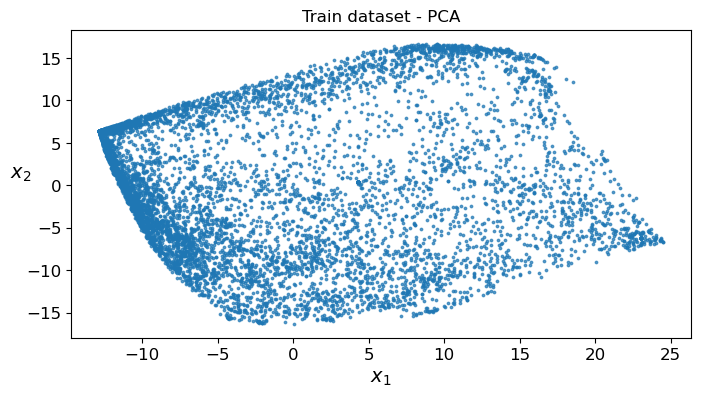

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca2 = pca.fit_transform(x_train, y_train)

plot_figure("Train dataset - PCA", X_pca2)

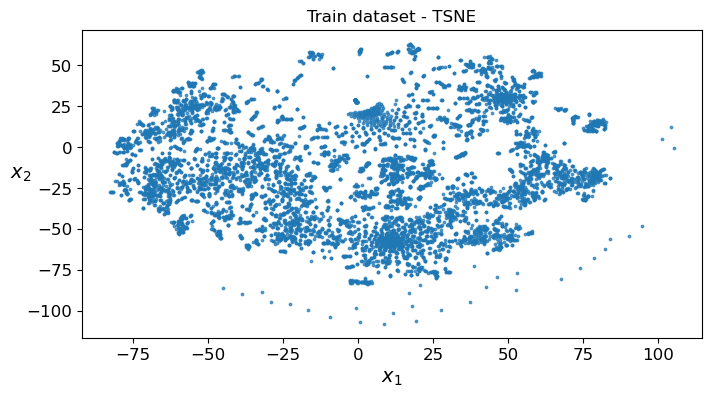

In [20]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
x_train_tsne = tsne.fit_transform(x_train)

plot_figure("Train dataset - TSNE", x_train_tsne)

Applied K-Means clusterer on the dataset and received the silhouette score. Used k = 10 at the start, i.e., 10 clusters.

In [21]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_train_scaled)

k = 10
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_pca)

In [22]:
tsne = TSNE(n_components=2, random_state=42)
x_train_tsne = tsne.fit_transform(x_train)

kmeans_tsne = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels_tsne = kmeans_tsne.fit_predict(x_train_tsne)

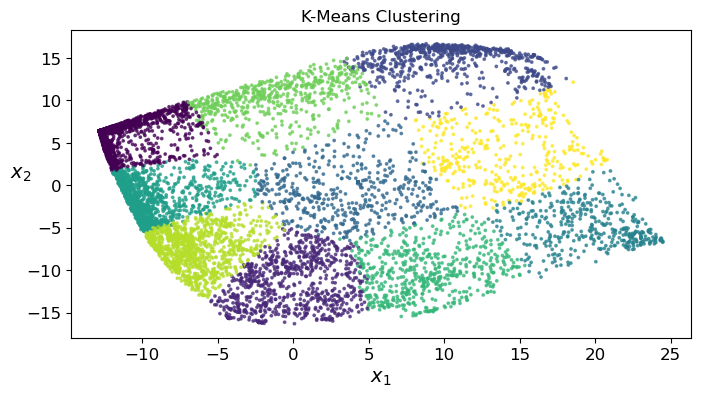

In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca3 = pca.fit_transform(x_train)

plot_figure("K-Means Clustering", X_pca3, cluster_labels)

In [24]:
from sklearn.metrics import accuracy_score

def accuracy(c_labels, X, y_train, k, model):
    y_train = np.asarray(y_train)
    cl = model.fit_predict(X)

    for i in range(k):
        c = {}
        for j in range(len(c_labels)):
            if i == c_labels[j]:
                ground_truth_label = int(y_train[j])
                if ground_truth_label in c:
                    c[ground_truth_label] += 1
                else:
                    c[ground_truth_label] = 1
        max_c = max(c, key=c.get)
        for l in range(len(c_labels)):
            if i == c_labels[l]:
                cl[l] = max_c

    accuracy = accuracy_score(y_train, cl)  # Compare with ground truth labels
    print(f"Clustering Accuracy: {accuracy}")
    return accuracy

In [25]:
a1 = accuracy(cluster_labels, X_pca, y_train, k, kmeans)

Clustering Accuracy: 0.3153766769865841


In [26]:
a2 = accuracy(cluster_labels_tsne, x_train_tsne, y_train, k, kmeans_tsne)

Clustering Accuracy: 0.3499484004127967


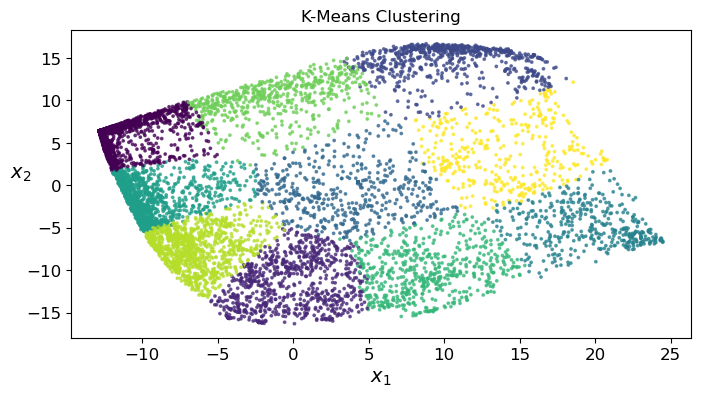

In [27]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca3 = pca.fit_transform(x_train)

plot_figure("K-Means Clustering", X_pca3, cluster_labels)

In [28]:
cluster_labels

array([3, 3, 3, ..., 7, 7, 7])

In [29]:
cluster_labels is kmeans.labels_

False

In [30]:
kmeans.inertia_

514304.3245714613

In [31]:
kmeans.cluster_centers_

array([[-2.67411456e+01,  1.38589970e+01],
       [-1.68671109e+00, -2.68776025e+01],
       [ 2.65605990e+01,  3.35155856e+01],
       [ 1.02837954e+01,  1.35115600e-02],
       [ 4.72576418e+01, -1.26538895e+01],
       [-2.32039116e+01, -2.43742894e+00],
       [ 2.03835488e+01, -2.45183221e+01],
       [-2.06839860e+00,  2.35059887e+01],
       [-1.68009739e+01, -1.64457663e+01],
       [ 3.46608469e+01,  8.57056614e+00]])

In [32]:
kmeans.labels_

array([4, 4, 4, ..., 3, 3, 3])

In [33]:
from sklearn.metrics import silhouette_score

silhouette_scores = silhouette_score(X_pca, cluster_labels)
print("Silhouette Score = ", silhouette_scores)

Silhouette Score =  0.5419757312839785


In [34]:
from sklearn.metrics import silhouette_score

silhouette_scores = silhouette_score(x_train_tsne, cluster_labels_tsne)
print("Silhouette Score = ", silhouette_scores)

Silhouette Score =  0.51389146


In [35]:
# Reference : https://colab.research.google.com/drive/1wq7JGYCT6Ctgd572KN9_QuIJwCS9tNo5?usp=sharing#scrollTo=7ZtUIKwNEcFS
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

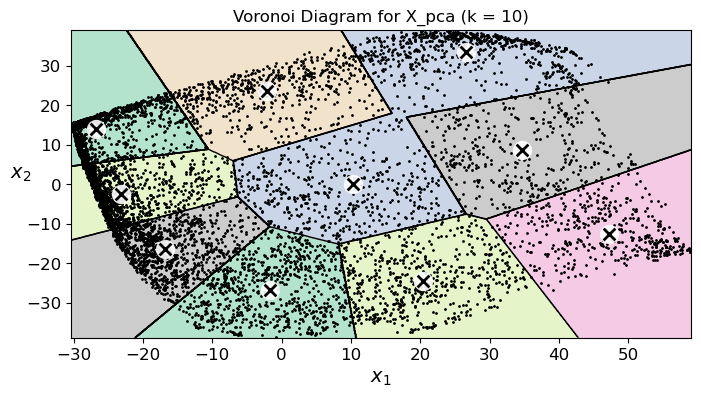

In [36]:
plt.figure(figsize=(8, 4))
plt.title("Voronoi Diagram for X_pca (k = 10)")
plot_decision_boundaries(kmeans, X_pca)
plt.show()

In [37]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, recall_score, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score,cross_val_predict

def assign_cluster_labels(c_labels, X, y_train, k, model):
    y_train = np.asarray(y_train)
    cl = model.fit_predict(X)

    for i in range(k):
        c = {}
        for j in range(len(c_labels)):
            if i == c_labels[j]:
                ground_truth_label = int(y_train[j])
                if ground_truth_label in c:
                    c[ground_truth_label] += 1
                else:
                    c[ground_truth_label] = 1
        max_c = max(c, key=c.get)
        for l in range(len(c_labels)):
            if i == c_labels[l]:
                cl[l] = max_c
    return cl


In [38]:
def calculate_metrics_and_mean(X_train, y_train, y_pred, model):
    report = classification_report(y_train, y_pred, output_dict=True,zero_division=0)
    report_df = pd.DataFrame(report).T.iloc[:-3].drop(columns='support')
    cm = confusion_matrix(y_train, y_pred)
    tp = np.diagonal(cm)
    fn = np.sum(cm, axis=1) - tp
    fp = np.sum(cm, axis=0) - tp
    tn = np.sum(cm) - (tp + fn + fp)
    tp_rate = tp / (tp + fn)
    fp_rate = fp / (fp + tn)
    tp_fp_rate_df = pd.DataFrame({'TPR': tp_rate, 'FPR': fp_rate}, index=range(len(tp_rate)))
    specificity = []
    unique_labels = np.unique(y_train)
    try:
        for i in range(len(unique_labels)):
            true_negative = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i]) + cm[i, i]
            total_negative = np.sum(cm) - np.sum(cm[i, :])
            specificity.append(true_negative / total_negative)
        specificity_df = pd.DataFrame({'specificity': specificity}, index=unique_labels)
    except:
        specificity_df = pd.DataFrame({'specificity': 0}, index=unique_labels)
    try:
        sensitivity = recall_score(y_train, y_pred, average=None)
        sensitivity_df = pd.DataFrame({'sensitivity': sensitivity}, index=unique_labels)
    except:
        sensitivity_df = pd.DataFrame({'sensitivity': 0}, index=unique_labels)

    result_df = pd.concat([report_df.reset_index().drop(columns='index'),
                           tp_fp_rate_df.reset_index().drop(columns='index'),
                           specificity_df.reset_index().drop(columns='index'),
                           sensitivity_df.reset_index().drop(columns='index')], axis=1)
    
    try:
        auc = roc_auc_score(y_train, model.predict_proba(X_train), multi_class='ovr')
    except:
        auc = 0
    auc_df = pd.DataFrame({'AUC': auc}, index=unique_labels)
    
    accuracy = accuracy_score(y_train, y_pred)
    accuracy_df = pd.DataFrame({'accuracy': [accuracy]})
    
    try:
        cross_val_scores = cross_val_score(model, X_train, y_train, cv=10)
    except :
        try:
            cross_val_scores = cross_val_predict(model, X_train, y_train, cv=10)
        except:
            cross_val_scores = [0]

    cross_val_mean = np.mean(cross_val_scores)
    cross_val_std = np.std(cross_val_scores)
    cross_val_df = pd.DataFrame({'CV mean': [cross_val_mean], 'CV std': [cross_val_std]})

    result_df = pd.concat([result_df, auc_df, accuracy_df, cross_val_df], axis=1)
    mean_values = pd.DataFrame(result_df.mean()).transpose()
    mean_values.index = ['mean']
    result_df = pd.concat([result_df, mean_values])
    
    return result_df

In [39]:
y_pred = assign_cluster_labels(cluster_labels, X_pca, y_train, k, kmeans)
kdmeans_pca_res = calculate_metrics_and_mean(X_pca, y_train, y_pred, kmeans).drop(columns='AUC')
kdmeans_pca_res

,precision,recall,f1-score,TPR,FPR,specificity,sensitivity,accuracy,CV mean,CV std
0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.315377,-55713.953979,14153.33354
1,0.482252,0.177477,0.259467,0.177477,0.056627,0.943373,0.177477,NaN,NaN,NaN
2,0.304466,0.696889,0.423784,0.696889,0.481452,0.518548,0.696889,NaN,NaN,NaN
3,0.324841,0.289362,0.306077,0.289362,0.102415,0.897585,0.289362,NaN,NaN,NaN
4,0.278071,0.346465,0.308523,0.346465,0.230999,0.769001,0.346465,NaN,NaN,NaN
5,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,NaN,NaN,NaN
6,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,NaN,NaN,NaN
7,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,NaN,NaN,NaN
8,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,NaN,NaN,NaN
9,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,NaN,NaN,NaN


In [40]:
y_pred=assign_cluster_labels(cluster_labels_tsne, x_train_tsne, y_train, k, kmeans_tsne)
kdmeans_tsne_res = calculate_metrics_and_mean(x_train_tsne, y_train, y_pred, kmeans_tsne).drop(columns='AUC')
kdmeans_tsne_res

,precision,recall,f1-score,TPR,FPR,specificity,sensitivity,accuracy,CV mean,CV std
0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.349948,-218764.239844,65293.157158
1,0.475399,0.335135,0.393131,0.335135,0.109906,0.890094,0.335135,NaN,NaN,NaN
2,0.370459,0.412444,0.390326,0.412444,0.211962,0.788038,0.412444,NaN,NaN,NaN
3,0.365947,0.204255,0.262176,0.204255,0.060266,0.939734,0.204255,NaN,NaN,NaN
4,0.301308,0.605051,0.402283,0.605051,0.360311,0.639689,0.605051,NaN,NaN,NaN
5,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,NaN,NaN,NaN
6,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,NaN,NaN,NaN
7,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,NaN,NaN,NaN
8,0.271879,0.431481,0.333572,0.431481,0.068197,0.931803,0.431481,NaN,NaN,NaN
9,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,NaN,NaN,NaN


### 2) Hard & Soft Clustering

#### DBSCAN Clustering (Hard Clustering)

To find the best value for epsilon, we first plot the K-distance graph

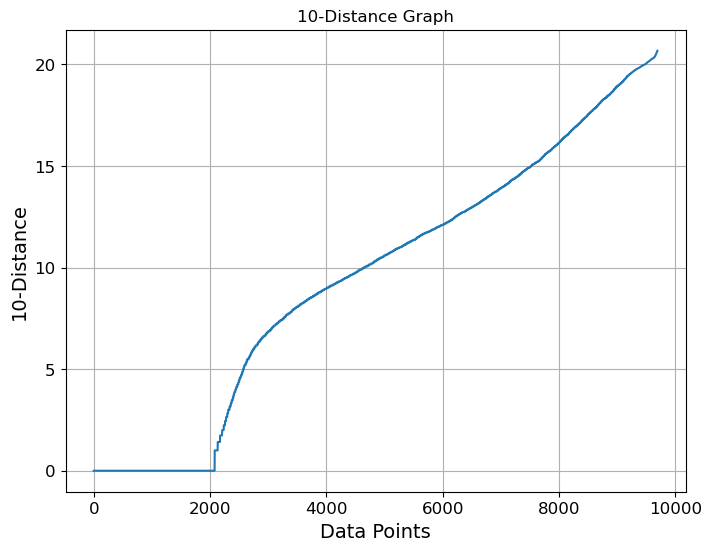

In [41]:
from sklearn.neighbors import NearestNeighbors

# Compute k-distances
k = 10 
nn = NearestNeighbors(n_neighbors=k)
nn.fit(x_train)
distances, _ = nn.kneighbors(x_train)

# Sort distances
sorted_distances = np.sort(distances[:, -1])

# Plot k-distance graph
plt.figure(figsize=(8, 6))
plt.plot(range(len(x_train)), sorted_distances)
plt.xlabel("Data Points")
plt.ylabel(f"{k}-Distance")
plt.title(f"{k}-Distance Graph")
plt.grid()
plt.show()

In [42]:
from sklearn.cluster import DBSCAN

# nos 14, 200, silhuette = 31
# nos 14.3, 210, silhuette = 32
dbscan = DBSCAN(eps=14.6, min_samples=210) 

dbscan.fit(x_train)

labels_dbscan = dbscan.labels_
print("Labels", labels_dbscan)

unique_labels, counts = np.unique(labels_dbscan, return_counts=True)

# Create a dictionary to store the counts for each label
label_counts = dict(zip(unique_labels, counts))

# Print the counts
for label, count in label_counts.items():
    if label == -1:
        print(f"Noise Points: {count} data points")
    else:
        print(f"Cluster {label}: {count} data points")

Labels [-1 -1 -1 ... -1 -1 -1]
Noise Points: 2816 data points
Cluster 0: 731 data points
Cluster 1: 3910 data points
Cluster 2: 231 data points
Cluster 3: 2002 data points


In [43]:
dbscan2 = DBSCAN(eps=8, min_samples=15)
dbscan2.fit(x_train)

labels_dbscan2 = dbscan2.labels_
print("Labels", labels_dbscan2)

unique_labels2, counts2 = np.unique(labels_dbscan2, return_counts=True)

# Create a dictionary to store the counts for each label
label_counts2 = dict(zip(unique_labels2, counts2))

# Print the counts
for label2, count2 in label_counts2.items():
    if label == -1:
        print(f"Noise Points: {count2} data points")
    else:
        print(f"Cluster {label2}: {count2} data points")

Labels [-1 -1 -1 ... -1 -1 -1]
Cluster -1: 5923 data points
Cluster 0: 1181 data points
Cluster 1: 83 data points
Cluster 2: 2002 data points
Cluster 3: 164 data points
Cluster 4: 15 data points
Cluster 5: 33 data points
Cluster 6: 47 data points
Cluster 7: 110 data points
Cluster 8: 32 data points
Cluster 9: 15 data points
Cluster 10: 37 data points
Cluster 11: 16 data points
Cluster 12: 32 data points


We tried to play around with more epsilon and min_sample values however, on using PCA and TSNE, it only produced noise clusters.
So we chose different values for them both to have clusters with labels other than -1

Cluster -1: 716 data points
Cluster 0: 8686 data points
Cluster 1: 288 data points
Silhouette Score DBSCAN + PCA =  0.2281603689424049


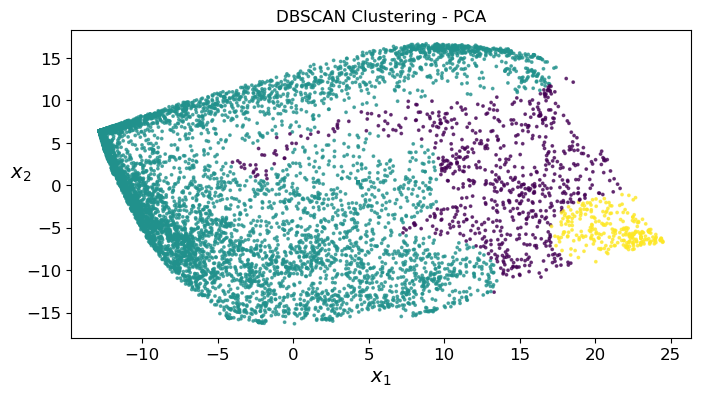

In [44]:
pca = PCA(n_components=2)
X_pca_db = pca.fit_transform(x_train)

dbscan2 = DBSCAN(eps=3, min_samples=180) 
labels_dbscan_pca = dbscan2.fit_predict(X_pca_db)

unique_labels6, counts6 = np.unique(labels_dbscan_pca, return_counts=True)

# Create a dictionary to store the counts for each label
label_counts6 = dict(zip(unique_labels6, counts6))

# Print the counts
for label6, count6 in label_counts6.items():
    if label == -1:
        print(f"Noise Points: {count6} data points")
    else:
        print(f"Cluster {label6}: {count6} data points")

silhouette_scores_dbscan = silhouette_score(X_pca_db, labels_dbscan_pca)
print("Silhouette Score DBSCAN + PCA = ", silhouette_scores_dbscan)

plot_figure("DBSCAN Clustering - PCA", X_pca_db, labels_dbscan_pca)

In [45]:
y_pred=assign_cluster_labels(labels_dbscan_pca, _db, y_train, 2, dbscan)
dbscan_pca_res=calculate_metrics_and_mean(_db, y_train, y_pred, dbscan).drop(columns=['sensitivity','AUC','CV mean','CV std'])
dbscan_pca_res

,precision,recall,f1-score,TPR,FPR,specificity,accuracy
0,0.078212,0.266667,0.120950,0.266667,0.069620,0.930380,0.240764
1,0.513889,0.066667,0.118022,0.066667,0.018742,0.981258,NaN
2,0.245107,0.946222,0.389356,0.946222,0.881317,0.118683,NaN
3,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,NaN
4,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,NaN
5,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,NaN
6,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,NaN
7,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,NaN
8,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,NaN
9,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,NaN


In [46]:
acc_dbscan_pca = accuracy(labels_dbscan_pca, X_pca_db, y_train, 2, dbscan)
# print("Accuracy of DBSCAN with 2 clusters using PCA =", acc_dbscan_pca)

Clustering Accuracy: 0.24076367389060888


Labels [-1 -1 -1 ... -1 -1 -1]
Cluster -1: 7786 data points
Cluster 0: 1904 data points
Silhouette Score DBSCAN + TSNE =  0.14862524


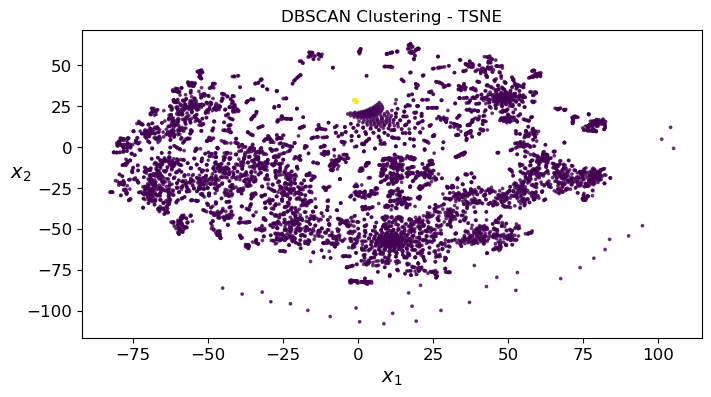

In [47]:
dbscan_tsne = TSNE(n_components=2, random_state=42)
db_tsne = dbscan_tsne.fit_transform(x_train)

dbscan = DBSCAN(eps=2.9, min_samples=100) 
labels_dbscan_tsne = dbscan.fit_predict(db_tsne)
print("Labels", labels_dbscan_tsne)

unique_labels5, counts5 = np.unique(labels_dbscan_tsne, return_counts=True)

# Create a dictionary to store the counts for each label
label_counts5 = dict(zip(unique_labels5, counts5))

# Print the counts
for label5, count5 in label_counts5.items():
    if label == -1:
        print(f"Noise Points: {count5} data points")
    else:
        print(f"Cluster {label5}: {count5} data points")

silhouette_scores_db_tsne = silhouette_score(db_tsne, labels_dbscan_tsne)
print("Silhouette Score DBSCAN + TSNE = ", silhouette_scores_db_tsne)

plot_figure("DBSCAN Clustering - TSNE", db_tsne, labels_dbscan_tsne)

In [48]:
y_pred=assign_cluster_labels(labels_dbscan, db_tsne, y_train, 2, dbscan)
pd.DataFrame(y_pred).value_counts()
# 10 being noise class
dbscan_tsne_res=calculate_metrics_and_mean(db_tsne, y_train, y_pred, dbscan).drop(columns=['sensitivity','AUC','CV mean','CV std']).drop(10)
dbscan_tsne_res


C:\Users\ishaq\AppData\Local\Temp\ipykernel_11948\386587433.py:9: RuntimeWarning: invalid value encountered in divide
  tp_rate = tp / (tp + fn)
c:\Users\ishaq\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,TPR,FPR,specificity,accuracy
0,0.000000,0.000000,0.000000,NaN,0.324561,0.675439,0.144892
1,0.000000,0.000000,0.000000,0.000000,0.200844,0.799156,NaN
2,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,NaN
3,0.281586,0.489333,0.357468,0.489333,0.377554,0.622446,NaN
4,0.414501,0.214894,0.283045,0.214894,0.051691,0.948309,NaN
5,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,NaN
6,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,NaN
7,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,NaN
8,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,NaN
9,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,NaN


In [49]:
acc_dbscan_tsne = accuracy(labels_dbscan, db_tsne, y_train, 2, dbscan)
# print("Accuracy of DBSCAN with 2 clusters using TSNE =", acc_dbscan_tsne)

Clustering Accuracy: 0.14489164086687306


#### Fuzzy C Means Clustering (Soft Clustering)

In [50]:
#Added this to ensure everyone can run it
!pip install fuzzy-c-means


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [51]:
def accuracy_fcm(c_labels, X, y_train, k, model):
    y_train = np.asarray(y_train)
    model.fit(X)
    cl = model.predict(X)

    for i in range(k):
        c = {}
        for j in range(len(c_labels)):
            if i == c_labels[j]:
                ground_truth_label = int(y_train[j])
                if ground_truth_label in c:
                    c[ground_truth_label] += 1
                else:
                    c[ground_truth_label] = 1
        if c == {} :
            for l in range(len(c_labels)):
                if i == c_labels[l]:
                    c_labels[l] = -1  
        else:
            max_c = max(c, key=c.get)
            for l in range(len(c_labels)):
                if i == c_labels[l]:
                    c_labels[l] = max_c

    clustering_accuracy = accuracy_score(y_train, c_labels)
    print(f"Clustering Accuracy: {clustering_accuracy}")
    return clustering_accuracy

In [52]:
def assign_cluster_labels_fcm(c_labels, X, y_train, k, model):
    y_train = np.asarray(y_train)
    model.fit(X)
    cl = model.predict(X)

    for i in range(k):
        c = {}
        for j in range(len(c_labels)):
            if i == c_labels[j]:
                ground_truth_label = int(y_train[j])
                if ground_truth_label in c:
                    c[ground_truth_label] += 1
                else:
                    c[ground_truth_label] = 1
        if c == {} :
            for l in range(len(c_labels)):
                if i == c_labels[l]:
                    c_labels[l] = -1  
        else:
            max_c = max(c, key=c.get)
            for l in range(len(c_labels)):
                if i == c_labels[l]:
                    c_labels[l] = max_c
    return c_labels

In [53]:
from fcmeans import FCM

fcm = FCM(n_clusters=10)
fcm.fit(x_train)

fcm_centers = fcm.centers
print("Centers:", fcm_centers)

fcm_labels = fcm.predict(x_train)
print("Labels:", fcm_labels)

Centers: [[0.70245394 0.70405865 0.70883999 ... 0.75906216 0.75397206 0.7619471 ]
 [0.70542366 0.70697088 0.71179373 ... 0.76126662 0.756183   0.7642108 ]
 [0.54022239 0.54029649 0.54035718 ... 0.54411287 0.54387684 0.54399947]
 ...
 [0.70357533 0.70515841 0.70995552 ... 0.75989313 0.75480542 0.76280048]
 [0.93142368 0.9371485  0.94405826 ... 0.96427798 0.96543738 0.9656596 ]
 [0.18878063 0.18732844 0.18625426 ... 0.6163297  0.58521164 0.57629877]]
Labels: [0 0 0 ... 9 9 9]


Labels: [4 4 4 ... 0 0 0]
Silhouette Score FCM + PCA =  0.5271053632342285


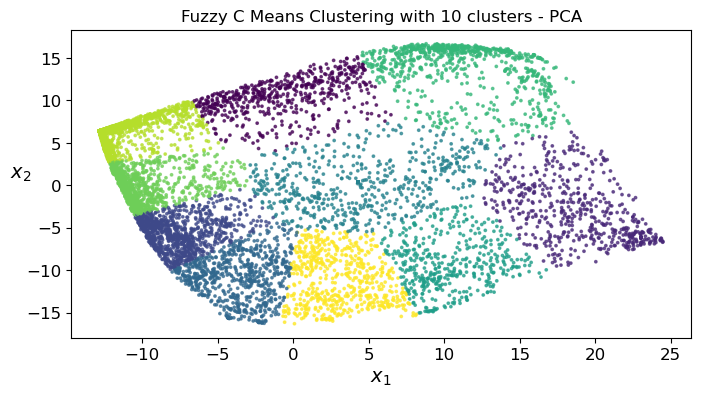

In [54]:
pca = PCA(n_components=2)
X_pca_fcm = pca.fit_transform(x_train)

fcm = FCM(n_clusters=10)
fcm.fit(X_pca_fcm)

fcm_labels_pca = fcm.predict(X_pca_fcm)
print("Labels:", fcm_labels_pca)

silhouette_scores_fcm = silhouette_score(X_pca_fcm, fcm_labels_pca)
print("Silhouette Score FCM + PCA = ", silhouette_scores_fcm)

plot_figure("Fuzzy C Means Clustering with 10 clusters - PCA", X_pca_fcm, fcm_labels_pca)

In [55]:
y_pred=assign_cluster_labels_fcm(fcm_labels_pca, X_pca_fcm, y_train, 10, fcm)
fcm_pca_res=calculate_metrics_and_mean(X_pca_fcm, y_train, y_pred, fcm).drop(columns=['AUC','CV mean','CV std'])
fcm_pca_res

,precision,recall,f1-score,TPR,FPR,specificity,sensitivity,accuracy
0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.303715
1,0.429406,0.198649,0.271635,0.198649,0.078447,0.921553,0.198649,NaN
2,0.286464,0.679111,0.402954,0.679111,0.511559,0.488441,0.679111,NaN
3,0.369032,0.202837,0.261785,0.202837,0.059058,0.940942,0.202837,NaN
4,0.269381,0.347475,0.303485,0.347475,0.242023,0.757977,0.347475,NaN
5,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,NaN
6,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,NaN
7,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,NaN
8,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,NaN
9,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,NaN


In [56]:
acc_fcm_pca = accuracy_fcm(fcm_labels_pca, X_pca_fcm, y_train, 10, fcm)

Clustering Accuracy: 0.30371517027863776


Labels: [3 3 3 ... 1 1 1]
Silhouette Score FCM + TSNE =  0.5121019


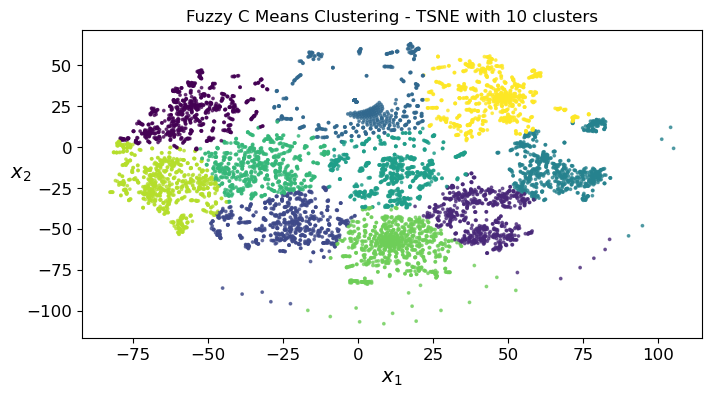

In [57]:
fcm_tsne = TSNE(n_components=2, random_state=42)
tsne_fcm = fcm_tsne.fit_transform(x_train)

fcm = FCM(n_clusters=10)
fcm.fit(tsne_fcm)

fcm_labels_tsne = fcm.predict(tsne_fcm)
print("Labels:", fcm_labels_tsne)

silhouette_scores_fcm_tsne = silhouette_score(tsne_fcm, fcm_labels_tsne)
print("Silhouette Score FCM + TSNE = ", silhouette_scores_fcm_tsne)

plot_figure("Fuzzy C Means Clustering - TSNE with 10 clusters", tsne_fcm, fcm_labels_tsne)

In [58]:
y_pred=assign_cluster_labels_fcm(fcm_labels_tsne, tsne_fcm, y_train, 10, fcm)
fcm_tsne_res=calculate_metrics_and_mean(tsne_fcm, y_train, y_pred, fcm).drop(columns=['AUC','CV mean','CV std'])
fcm_tsne_res

,precision,recall,f1-score,TPR,FPR,specificity,sensitivity,accuracy
0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.309185
1,0.462523,0.341892,0.393162,0.341892,0.118072,0.881928,0.341892,NaN
2,0.301778,0.558222,0.391765,0.558222,0.390591,0.609409,0.558222,NaN
3,0.252380,0.695745,0.370398,0.695745,0.350966,0.649034,0.695745,NaN
4,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,NaN
5,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,NaN
6,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,NaN
7,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,NaN
8,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,NaN
9,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,NaN


In [59]:
acc_fcm_tsne = accuracy_fcm(fcm_labels_tsne, tsne_fcm, y_train, 10, fcm)

Clustering Accuracy: 0.3091847265221878


Fuzzy C Means with 2 clusters

In [60]:
fcm2 = FCM(n_clusters=2)
fcm2.fit(x_train)

fcm_centers2 = fcm2.centers
print("FCM Centres")
print(fcm_centers2)

fcm_labels2 = fcm2.predict(x_train)
print("FCM Labels")
print(fcm_labels2)

FCM Centres
[[0.80069045 0.80148419 0.80760128 ... 0.85142116 0.84739815 0.85470716]
 [0.52886528 0.53020832 0.53110725 ... 0.59206142 0.58812694 0.58969631]]
FCM Labels
[1 1 1 ... 1 1 1]


Labels: [2 2 2 ... 3 3 3]
Silhouette Score FCM + PCA with 2 clusters =  0.22703227142437304


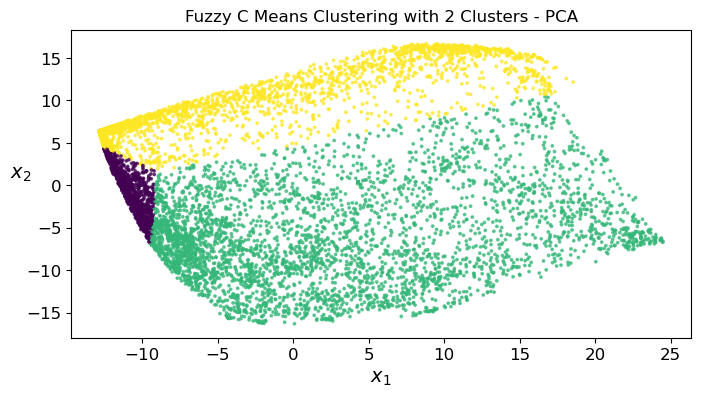

In [61]:
pca = PCA(n_components=2)
X_pca_fcm2 = pca.fit_transform(x_train)

fcm2 = FCM(n_clusters=2)
fcm2.fit(X_pca_fcm2)

fcm_labels_pca2 = fcm.predict(X_pca_fcm2)
print("Labels:", fcm_labels_pca2)

silhouette_scores_fcm2 = silhouette_score(X_pca_fcm2, fcm_labels_pca2)
print("Silhouette Score FCM + PCA with 2 clusters = ", silhouette_scores_fcm2)

plot_figure("Fuzzy C Means Clustering with 2 Clusters - PCA", X_pca_fcm2, fcm_labels_pca2)

In [62]:
y_pred=assign_cluster_labels_fcm(fcm_labels_pca2, X_pca_fcm2, y_train, 2, fcm)
fcm2_pca_res = calculate_metrics_and_mean(X_pca_fcm2, y_train, y_pred, fcm).drop(columns=['AUC','CV mean','CV std'])
fcm2_pca_res

,precision,recall,f1-score,TPR,FPR,specificity,sensitivity,accuracy
0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.247059
1,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,NaN
2,0.238188,0.761778,0.362905,0.761778,0.736828,0.263172,0.761778,NaN
3,0.272654,0.482270,0.348361,0.482270,0.219082,0.780918,0.482270,NaN
4,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,NaN
5,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,NaN
6,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,NaN
7,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,NaN
8,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,NaN
9,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,NaN


In [63]:
acc_fcm_pca2 = accuracy_fcm(fcm_labels_pca2, X_pca_fcm2, y_train, 2, fcm)

Clustering Accuracy: 0.24705882352941178


Labels: [5 5 5 ... 8 8 8]
Silhouette Score FCM + TSNE with 2 clusters =  0.17783472


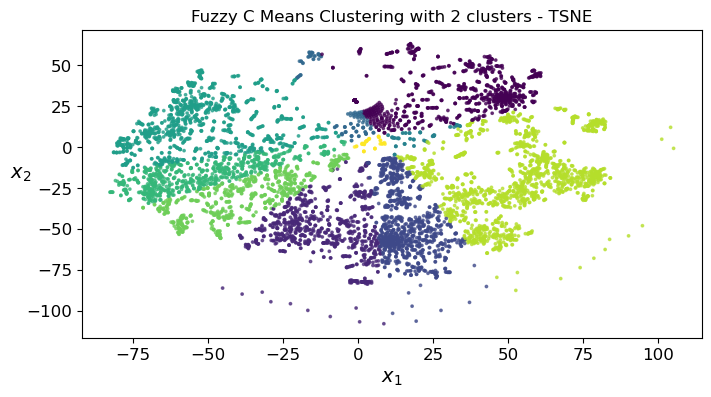

In [64]:
fcm_tsne = TSNE(n_components=2, random_state=42)
tsne_fcm2 = fcm_tsne.fit_transform(x_train)

fcm2 = FCM(n_clusters=2)
fcm2.fit(tsne_fcm2)

fcm_labels_tsne2 = fcm.predict(tsne_fcm2)
print("Labels:", fcm_labels_tsne2)

silhouette_scores_fcm_tsne2 = silhouette_score(tsne_fcm2, fcm_labels_tsne2)
print("Silhouette Score FCM + TSNE with 2 clusters = ", silhouette_scores_fcm_tsne2)

plot_figure("Fuzzy C Means Clustering with 2 clusters - TSNE", tsne_fcm2, fcm_labels_tsne2)

In [65]:
y_pred=assign_cluster_labels_fcm(fcm_labels_tsne2, tsne_fcm2, y_train, 2, fcm)
fcm2_tsne_res=calculate_metrics_and_mean(tsne_fcm2, y_train, y_pred, fcm).drop(columns=['AUC','CV mean','CV std'])
fcm2_tsne_res

,precision,recall,f1-score,TPR,FPR,specificity,sensitivity,accuracy
0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.15098
1,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,NaN
2,0.260442,0.235556,0.247375,0.235556,0.202285,0.797715,0.235556,NaN
3,0.026087,0.002128,0.003934,0.002128,0.013527,0.986473,0.002128,NaN
4,0.251794,0.372222,0.300387,0.372222,0.284047,0.715953,0.372222,NaN
5,0.000000,0.000000,0.000000,0.000000,0.127954,0.872046,0.000000,NaN
6,0.000000,0.000000,0.000000,0.000000,0.086710,0.913290,0.000000,NaN
7,0.000000,0.000000,0.000000,0.000000,0.079048,0.920952,0.000000,NaN
8,0.106866,0.357407,0.164535,0.357407,0.176284,0.823716,0.357407,NaN
9,0.000000,0.000000,0.000000,0.000000,0.004034,0.995966,0.000000,NaN


In [66]:
acc_fcm_tsne2 = accuracy_fcm(fcm_labels_tsne2, tsne_fcm2, y_train, 2, fcm)

Clustering Accuracy: 0.15098039215686274


### 3) Determining Optimal Number of Clusters

In [67]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

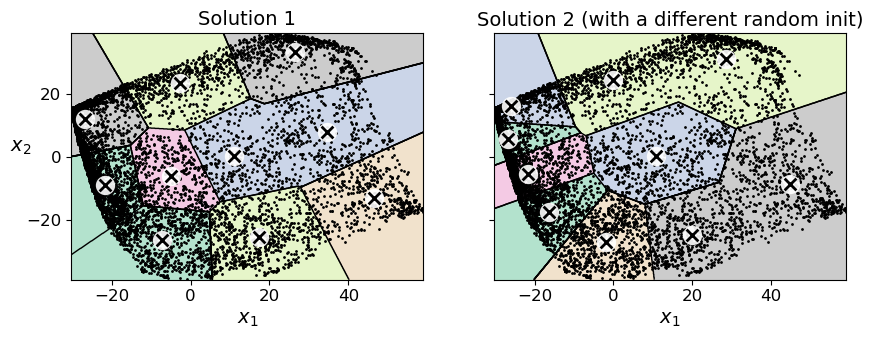

In [68]:
kmeans_rnd_init1 = KMeans(n_clusters=10, init="random", n_init=1,
                         algorithm="lloyd", random_state=44)
kmeans_rnd_init2 = KMeans(n_clusters=10, init="random", n_init=1,
                         algorithm="lloyd", random_state=50)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X_pca,
                          "Solution 1", "Solution 2 (with a different random init)")
plt.show()

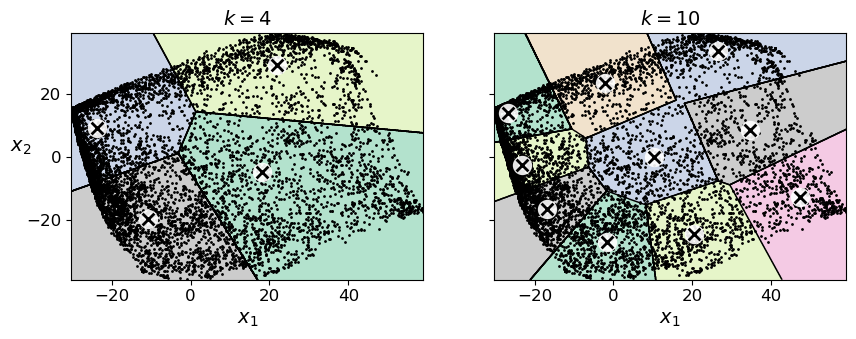

In [69]:
kmeans_k4 = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans_k10 = KMeans(n_clusters=10, random_state=42, n_init=10)

plot_clusterer_comparison(kmeans_k4, kmeans_k10, X_pca, "$k=4$", "$k=10$")
plt.show()

In [70]:
max_cluster=13
kmeans_per_k = [KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_pca)
                for k in range(1, max_cluster)]
inertias = [model.inertia_ for model in kmeans_per_k]

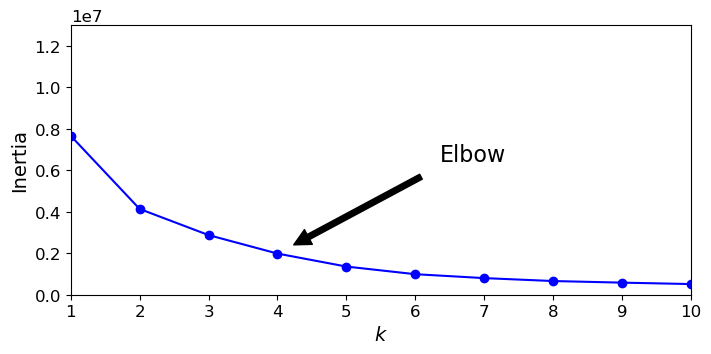

In [71]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, max_cluster), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 10, 0, 13000000])  # Adjust the y-axis limit as needed
plt.show()


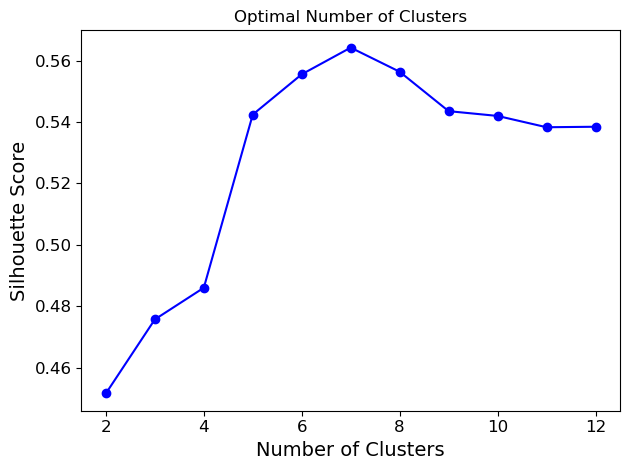

In [72]:
silhouette_scores = [silhouette_score(X_pca, model.labels_) for model in kmeans_per_k[1:]]     

plt.plot(range(2, max_cluster), silhouette_scores, "bo-")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Optimal Number of Clusters")
plt.tight_layout()
plt.show()

In [90]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

x_pca_scaled = X_pca + abs(X_pca).max()
x_tsne_scaled = x_train_tsne + abs(x_train_tsne).max()

gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

gnb.fit(X_pca, y_train)
mnb.fit(x_pca_scaled, y_train)
bnb.fit(X_pca, y_train)

y_pred_gnb_pca = gnb.predict(X_pca)
y_pred_mnb_pca = mnb.predict(x_pca_scaled)
y_pred_bnb_pca = bnb.predict(X_pca)

gnb_pca_res = calculate_metrics_and_mean(X_pca, y_train, y_pred_gnb_pca, gnb)
mnb_pca_res = calculate_metrics_and_mean(X_pca, y_train, y_pred_mnb_pca, mnb)
bnb_pca_res = calculate_metrics_and_mean(X_pca, y_train, y_pred_bnb_pca, bnb)

gnb.fit(x_train_tsne, y_train)
mnb.fit(x_tsne_scaled, y_train)
bnb.fit(x_train_tsne, y_train)

y_pred_gnb_tsne = gnb.predict(x_train_tsne)
y_pred_mnb_tsne = mnb.predict(x_tsne_scaled)
y_pred_bnb_tsne = bnb.predict(x_train_tsne)

gnb_tsne_res = calculate_metrics_and_mean(x_train_tsne, y_train, y_pred_gnb_tsne, gnb)
mnb_tsne_res = calculate_metrics_and_mean(x_train_tsne, y_train, y_pred_mnb_tsne, mnb)
bnb_tsne_res = calculate_metrics_and_mean(x_train_tsne, y_train, y_pred_bnb_tsne, bnb)

c:\Users\ishaq\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\ishaq\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\ishaq\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\ishaq\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

In [93]:
import pandas as pd

dataframes = [kdmeans_pca_res, kdmeans_tsne_res, dbscan_pca_res, dbscan_tsne_res,
              fcm_pca_res, fcm_tsne_res, fcm2_pca_res, fcm2_tsne_res,
              gnb_pca_res, mnb_pca_res, bnb_pca_res, gnb_tsne_res, mnb_tsne_res, bnb_tsne_res]

columns_to_match = dataframes[0].columns
# for df in dataframes:
#     if not df.columns.equals(columns_to_match):
#         df.drop(columns=df.columns.difference(columns_to_match), inplace=True)

names = ['kdmeans_pca_res', 'kdmeans_tsne_res', 'dbscan_pca_res', 'dbscan_tsne_res',
         'fcm_pca_res', 'fcm_tsne_res', 'fcm2c_pca_res', 'fcm2c_tsne_res',
         'gnb_pca_res', 'mnb_pca_res', 'bnb_pca_res', 'gnb_tsne_res', 'mnb_tsne_res', 'bnb_tsne_res']

appended_df = pd.concat([df.iloc[-1] for df in dataframes], axis=1).T

appended_df.index = names

appended_df


,precision,recall,f1-score,TPR,FPR,specificity,sensitivity,accuracy,CV mean,CV std
kdmeans_pca_res,0.138963,0.151019,0.129785,0.151019,0.087149,0.912851,0.151019,0.315377,-55713.953979,14153.333540
kdmeans_tsne_res,0.178499,0.198837,0.178149,0.198837,0.081064,0.918936,0.198837,0.349948,-218764.239844,65293.157158
dbscan_pca_res,0.083721,0.127956,0.062833,0.127956,0.096968,0.903032,NaN,0.240764,NaN,NaN
dbscan_tsne_res,0.063281,0.064021,0.058228,0.070423,0.086786,0.904535,NaN,0.144892,NaN,NaN
fcm_pca_res,0.135428,0.142807,0.123986,0.142807,0.089109,0.910891,0.142807,0.303715,NaN,NaN
fcm_tsne_res,0.101668,0.159586,0.115533,0.159586,0.085963,0.914037,0.159586,0.309185,NaN,NaN
fcm2c_pca_res,0.051084,0.124405,0.071127,0.124405,0.095591,0.904409,0.124405,0.247059,NaN,NaN
fcm2c_tsne_res,0.064519,0.096731,0.071623,0.096731,0.097389,0.902611,0.096731,0.150980,NaN,NaN
gnb_pca_res,0.094269,0.136024,0.105746,0.136024,0.091255,0.908745,0.136024,0.285655,0.282869,0.049239
mnb_pca_res,0.075162,0.115412,0.081092,0.115412,0.095270,0.904730,0.115412,0.213209,0.000000,0.000000
